In [1]:
import sys
import math
import matplotlib.pyplot as plt
import cv2
sys.path.append('../')

from scripts.point_cloud_utils import send_point_cloud
from pyngp.common import *
from tqdm import tqdm
import pyngp.pyngp as ngp
from  scripts.ros_utils import get_image_tf_pair, send_tf



In [2]:
width = 854
height = 480
spp = 1 # 1 is fast 8 is default

objects = ['table', 'truck', 'coke']
testbed_map = {}
for obj in objects:
    testbed = ngp.Testbed()
    testbed.load_snapshot(f'../nerf/{obj}.ingp')
    testbed_map[obj] = testbed
def srgb_to_linear(img):
    limit = 0.04045
    return np.where(img > limit, np.power((img + 0.055) / 1.055, 2.4), img / 12.92)

def linear_to_srgb(img):
    limit = 0.0031308
    return np.where(img > limit, 1.055 * (img ** (1.0 / 2.4)) - 0.055, 12.92 * img)

camera_matrix = testbed_map['table'].camera_matrix

testbed_map['coke'].fov = testbed_map['table'].fov


17:57:16 SUCCESS  Initialized CUDA 12.0. Active GPU is #0: NVIDIA GeForce RTX 4090 [89]
17:57:16 INFO     Loading network snapshot from: ../nerf/table.ingp
17:57:19 DEBUG    GPUMemory: allocating 1.41 KB.
17:57:19 DEBUG    GPUMemory: allocating 144 B.
17:57:19 DEBUG    GPUMemory: allocating 144 B.
17:57:19 DEBUG    GPUMemory: allocating 144 B.
17:57:19 DEBUG    GPUMemory: allocating 144 B.
17:57:19 DEBUG    GPUMemory: allocating 8 B.
17:57:19 DEBUG    GPUMemory: allocating 1.12 KB.
17:57:19 DEBUG    GPUMemory: allocating 4 MB.
17:57:19 DEBUG    GPUMemory: allocating 8 MB.
17:57:19 DEBUG    GPUMemory: allocating 2 MB.
17:57:19 DEBUG    GPUMemory: allocating 64 KB.
17:57:19 INFO     GridEncoding:  Nmin=16 b=2 F=4 T=2^22 L=8
17:57:19 DEBUG    GridEncoding at level 0: resolution=16 params_in_level=4096
17:57:19 DEBUG    GridEncoding at level 1: resolution=32 params_in_level=32768
17:57:19 DEBUG    GridEncoding at level 2: resolution=64 params_in_level=262144
17:57:19 DEBUG    GridEncoding 

In [3]:
ros_image, tf = get_image_tf_pair(image_topics=['camera_image_l'], tf_names=['camera_frame_l'])
tf = tf[0]
ros_image = ros_image[0]

c2w = tf.copy()
c2w[0:3, 2] *= -1  # flip the y and z axis
c2w[0:3, 1] *= -1
c2w = c2w[[1, 0, 2, 3], :]
c2w[2, :] *= -1  # flip whole world upside down
tf_ngp = c2w
tf_ngp = tf_ngp[:-1, :]

testbed.set_nerf_camera_matrix(tf_ngp)
camera_matrix2 = testbed.camera_matrix.copy()

depth_buffer = 10000000*np.ones((height, width))
image_composed = np.zeros((height, width, 3))



for obj in objects:
    testbed = testbed_map[obj]
    camera_matrix_tmp = camera_matrix2.copy()
    if obj != 'table':
        tmp = (.2*(np.random.rand(3, 1)-.5) ).squeeze()
        tmp[2] = 0
        camera_matrix_tmp[:, -1] = camera_matrix_tmp[:, -1] + camera_matrix_tmp[:, :3] @ tmp
    testbed.camera_matrix = camera_matrix_tmp
    testbed.nerf.render_min_transmittance = 0.01
    testbed.render_mode = ngp.RenderMode.Shade
    testbed.color_space = ngp.ColorSpace.Linear
    image = testbed.render(width, height, spp, True)
    testbed.nerf.render_min_transmittance = 0.9
    testbed.render_mode = ngp.RenderMode.Depth
    depth = testbed.render(width, height, spp, True)
    depth = depth[:,:,0]
    inds = (depth < depth_buffer) * (depth > 0.2)
    image_composed[inds, 0] = image[inds, 0]
    image_composed[inds, 1] = image[inds, 1]
    image_composed[inds, 2] = image[inds, 2]
    depth_buffer[inds] = depth[inds]

image_composed = linear_to_srgb(image_composed)


17:57:26 DEBUG    GPUMemory: allocating 6.25 MB.
17:57:26 DEBUG    GPUMemory: allocating 1.56 MB.
17:57:26 DEBUG    GPUMemory: allocating 6.25 MB.
17:57:26 DEBUG    GPUMemoryArena: enlarging from 0 B to 258 MB
17:57:26 DEBUG    GPUMemoryArena: enlarging from 260 MB to 368 MB
17:57:26 DEBUG    GPUMemoryArena: enlarging from 370 MB to 479 MB
17:57:26 DEBUG    GPUMemoryArena: enlarging from 480 MB to 505 MB
17:57:26 DEBUG    GPUMemory: allocating 6.25 MB.
17:57:26 DEBUG    GPUMemory: allocating 1.56 MB.
17:57:26 DEBUG    GPUMemory: allocating 6.25 MB.
17:57:26 DEBUG    GPUMemoryArena: enlarging from 0 B to 258 MB
17:57:26 DEBUG    GPUMemoryArena: enlarging from 260 MB to 261 MB
17:57:26 DEBUG    GPUMemory: allocating 6.25 MB.
17:57:26 DEBUG    GPUMemory: allocating 1.56 MB.
17:57:26 DEBUG    GPUMemory: allocating 6.25 MB.
17:57:26 DEBUG    GPUMemoryArena: enlarging from 0 B to 458 MB
17:57:26 DEBUG    GPUMemoryArena: enlarging from 460 MB to 460 MB
17:57:26 DEBUG    GPUMemoryArena: enlarg

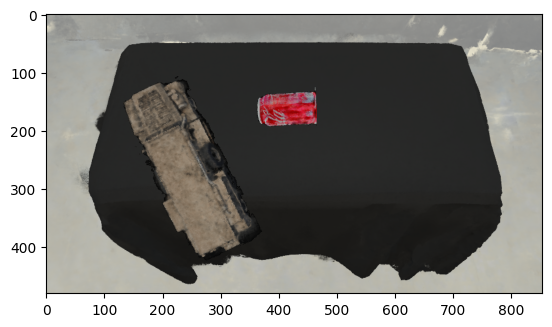

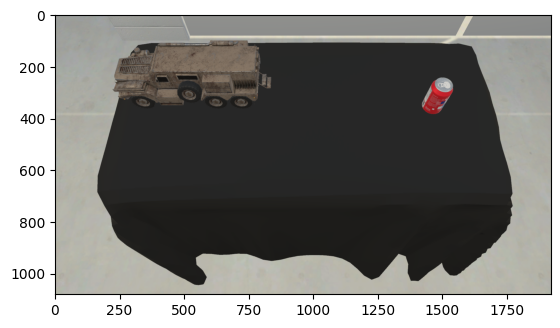

In [81]:
plt.figure()
plt.imshow(image_composed)
plt.figure()
plt.imshow(ros_image)

scale = 1.0
image_composed = cv2.resize(image_composed, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
ros_image = cv2.resize(ros_image, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC) 
tmp = np.max(depth_buffer)
depth_buffer = tmp*cv2.resize(depth_buffer/tmp, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR) 

In [82]:
sys.path.append('../unimatch_repo')

import torch
import torch.nn.functional as F
from unimatch.unimatch import UniMatch
from evaluate_flow import inference_flow
from utils.flow_viz import flow_to_image
from PIL import Image as im

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UniMatch(feature_channels=128,
                 num_scales=2,
                 upsample_factor=4,
                 num_head=1,
                 ffn_dim_expansion=4,
                 num_transformer_layers=6,
                 reg_refine=True,
                 task='flow').to(device)

trained_model_path = '../unimatch_repo/pretrained/gmflow-scale2-regrefine6-mixdata-train320x576-4e7b215d.pth'
loc = 'cuda:{}'.format(0) if torch.cuda.is_available() else 'cpu'
checkpoint = torch.load(trained_model_path, map_location=loc)
model.load_state_dict(checkpoint['model'], strict=False)
model.eval()

UniMatch(
  (backbone): CNNEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu1): ReLU(inplace=True)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
    

In [83]:
import sys
sys.path.append('../unimatch_repo')
import torch
import torch.nn.functional as F
from unimatch.unimatch import UniMatch
from dataloader.stereo import transforms
from utils.visualization import viz_depth_tensor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_stereo = UniMatch(feature_channels=128,
                 num_scales=2,
                 upsample_factor=4,
                 num_head=1,
                 ffn_dim_expansion=4,
                 num_transformer_layers=6,
                 reg_refine=True,
                 task='stereo').to(device)

trained_depth_path = '../unimatch_repo/pretrained/gmstereo-scale2-regrefine3-resumeflowthings-middleburyfthighres-a82bec03.pth'
loc = 'cuda:{}'.format(0) if torch.cuda.is_available() else 'cpu'
checkpoint = torch.load(trained_depth_path, map_location=loc)
model_stereo.load_state_dict(checkpoint['model'], strict=False)
model_stereo.eval()

UniMatch(
  (backbone): CNNEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu1): ReLU(inplace=True)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
    

0.12509608268737793


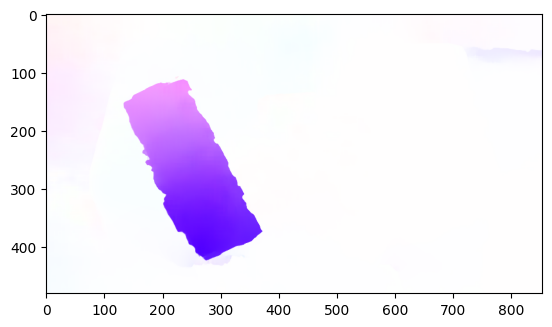

In [84]:

def get_flow(model, image1, image2): 
    padding_factor=32

    # the model is trained with size: width > height
    transpose_img = False
    if image1.size(-2) > image1.size(-1):
        image1 = torch.transpose(image1, -2, -1)
        image2 = torch.transpose(image2, -2, -1)
        transpose_img = True

    nearest_size = [int(np.ceil(image1.size(-2) / padding_factor)) * padding_factor,
                    int(np.ceil(image1.size(-1) / padding_factor)) * padding_factor]
    fixed_inference_size = None
    # fixed_inference_size = [val//2 for val in nearest_size] 
#     fixed_inference_size = (224, 384)

    # resize to nearest size or specified size
    inference_size = nearest_size if fixed_inference_size is None else fixed_inference_size

    assert isinstance(inference_size, list) or isinstance(inference_size, tuple)
    ori_size = image1.shape[-2:]

    # resize before inference
    if inference_size[0] != ori_size[0] or inference_size[1] != ori_size[1]:
        image1 = F.interpolate(image1, size=inference_size, mode='bilinear',
                               align_corners=True)
        image2 = F.interpolate(image2, size=inference_size, mode='bilinear',
                               align_corners=True)


    for i in range(1):
        import time
        start = time.time()
        with torch.inference_mode():
            results_dict = model(image1, image2,
                                attn_type='swin',
                                attn_splits_list=[2, 8],
                                corr_radius_list=[-1, 4],
                                prop_radius_list=[-1, 1],
                                num_reg_refine=6,
                                task='flow'
                                )
        print(time.time() - start)


    flow_pr = results_dict['flow_preds'][-1]

    # resize back
    if inference_size[0] != ori_size[0] or inference_size[1] != ori_size[1]:
        flow_pr = F.interpolate(flow_pr, size=ori_size, mode='nearest') # align_corners=True
        flow_pr[:, 0] = flow_pr[:, 0] * ori_size[-1] / inference_size[-1]
        flow_pr[:, 1] = flow_pr[:, 1] * ori_size[-2] / inference_size[-2]

    if transpose_img:
        flow_pr = torch.transpose(flow_pr, -2, -1)

    flow = flow_pr[0].permute(1, 2, 0).cpu().numpy()  # [H, W, 2]
    return flow 


image1 = np.array(255*image_composed[:,:,:3]).astype(np.uint8)
image2 = ros_image[:,:,:3]
image1 = torch.from_numpy(image1).permute(2, 0, 1).float().unsqueeze(0).to(device)
image2 = torch.from_numpy(image2).permute(2, 0, 1).float().unsqueeze(0).to(device)

flow = get_flow(model, image1, image2)
    
plt.figure()
vis_flow = flow_to_image(flow)
plt.imshow(vis_flow)

In [85]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def get_points(depth, tf_cam_world_inv, fov, width, height):
    fx = 2*np.tan(fov/2.0)
    fy = fx*width/height
    Z = depth
    [Xgrid, Ygrid] = np.meshgrid(np.linspace(-.5, .5, width), np.linspace(-.5, .5, height))
    X = (Xgrid)*Z/fx
    Y = (Ygrid)*Z/fy
    points = np.stack([X, Y, Z], axis=2);
    points = np.reshape(points, (-1, 3))
    points = (points @ tf_cam_world_inv[:3, :3].transpose()) + np.reshape(tf_cam_world_inv[:3, 3], (1, 3))
    
    return points

cached_render = {}
def render_nerf(testbed_map, tf_map, fov, width, height):
    all_points = []
    all_depth = []
    depth_buffer = 10000000*np.ones((height, width))
    image_composed = np.zeros((height, width, 3))
    object_inds = np.zeros((height, width), dtype=np.int32)
    
    
    for ind, obj in enumerate(testbed_map):
        testbed = testbed_map[obj]
        tf_nerf_cam = tf_map[obj]
        tf_cam_nerf = np.linalg.inv(tf_nerf_cam.detach().cpu().numpy())
        c2w = tf_cam_nerf.copy()
        c2w[0:3, 2] *= -1  # flip the y and z axis
        c2w[0:3, 1] *= -1
        c2w = c2w[[1, 0, 2, 3], :]
        c2w[2, :] *= -1  # flip whole world upside down
        tf_ngp = c2w
        tf_ngp = tf_ngp[:-1, :]
        testbed.set_nerf_camera_matrix(tf_ngp)

        if obj == 'table' and obj in cached_render:
            image, depth = cached_render[obj]
        else:
            testbed.nerf.render_min_transmittance = 0.01
            testbed.render_mode = ngp.RenderMode.Shade
            testbed.color_space = ngp.ColorSpace.Linear
            image = testbed.render(width, height, spp, True)
            testbed.nerf.render_min_transmittance = 0.9
            testbed.render_mode = ngp.RenderMode.Depth
            depth = testbed.render(width, height, spp, True)
        
        if obj == 'table' and obj not in cached_render:
            cached_render[obj] = (image, depth)
            
        depth = depth[:, :, 0]
        depth[depth < 0.1]  = 10000000
        inds = (depth < depth_buffer)
        image_composed[inds, 0] = image[inds, 0]
        image_composed[inds, 1] = image[inds, 1]
        image_composed[inds, 2] = image[inds, 2]
        depth_buffer[inds] = depth[inds]
        object_inds[inds] = ind
        
        all_depth.append(depth.flatten())
        points = get_points(depth, tf_cam_nerf, fov, width, height) 
        Rt_tensor = tf_nerf_cam[:3, :3].transpose(0, 1)
        p_tensor = tf_nerf_cam[:3, 3]
        points = torch.tensor(points, dtype=torch.float32, device='cuda', requires_grad=False)
        points_tensor = (points @ Rt_tensor) + torch.reshape(p_tensor, (1, 3)) # need grad
        all_points.append(points_tensor)
        
        
    all_points = torch.stack(all_points, axis=0)
    all_depth = torch.tensor(np.vstack(all_depth), dtype=torch.float32, device='cuda')
    min_z, inds = torch.min(all_depth, axis=0) # keepdim=True 
    
    x_vals = all_points[:, :, 0].flatten()
    y_vals = all_points[:, :, 1].flatten()
    z_vals = all_points[:, :, 2].flatten()
    
    inds = inds*inds.shape[0] + torch.linspace(0, inds.shape[0]-1, inds.shape[0], dtype=torch.int32, device='cuda')
    
    points_composed = torch.stack([x_vals[inds], y_vals[inds], z_vals[inds]], axis=1)
    image_composed = linear_to_srgb(image_composed)
    
    return points_composed, image_composed, object_inds  



def get_transform(rpy_params, xyz_params):
    rpy_params = torch.reshape(rpy_params, (3,1))
    xyz_params = torch.reshape(xyz_params, (3,1)) 
    ct = torch.cos(rpy_params);
    st = torch.sin(rpy_params);
    R00 = ct[0]*ct[2]*ct[1] - st[0]*st[2]
    R01 = -ct[0]*ct[1]*st[2] - st[0]*ct[2]
    R02 = ct[0]*st[1]
    R10 = st[0]*ct[2]*ct[1] + ct[0]*st[2]
    R11 = -st[0]*ct[1]*st[2] + ct[0]*ct[2]
    R12 = st[0]*st[1]
    R20 = -st[1]*ct[2]
    R21 = st[1]*st[2]
    R22 = ct[1]
    R0 = torch.hstack([R00, R01, R02])
    R1 = torch.hstack([R10, R11, R12])
    R2 = torch.hstack([R20, R21, R22])
    R = torch.stack([R0, R1, R2], axis=0);
        
    row = torch.tensor([[0.0, 0.0, 0.0, 1.0]], dtype=torch.float32, device='cuda')
    M = torch.hstack([R, xyz_params])
    T = torch.vstack([M, row])
    return T

class CorrespondenceNet(nn.Module):
    def __init__(self, testbed_map, width, height, tf):
        super(CorrespondenceNet, self).__init__()
        self.testbed_map = testbed_map
        self.width = width
        self.height = height
        self.objects = [key for key in testbed_map.keys() ]
#         tmp = 2*3.14*torch.rand(3*len(self.objects), dtype=torch.float32, device='cuda')
#         tmp[0::3] = 0
#         tmp[1::3] = 0
#         self.rpy = nn.Parameter(tmp)
#         tmp = .25 - .5*torch.rand(3*len(self.objects), dtype=torch.float32, device='cuda')
#         tmp[2::3] = 0
#         self.xyz = nn.Parameter(tmp)
        self.fov = testbed_map['table'].fov
        assert all([testbed_map[key].fov == self.fov for key in testbed_map])
        self.fov = math.pi*self.fov/180.0
        self.tf_cam_world = torch.tensor(tf, dtype=torch.float32, device='cuda') 
        self.default_transforms = {}
        self.tf_nerf_cam = {}
        
        
        for obj in self.objects:
            T = np.linalg.inv(tf)
            self.default_transforms[obj] = torch.tensor(T, dtype=torch.float32, device='cuda')
        for obj in self.objects:
            self.reset_transform(obj)
        
        
    def reset_transform(self, obj):
        if obj == 'table':
            self.tf_nerf_cam[obj] = self.default_transforms[obj]
            return
                
        box_tf = np.eye(4,4, dtype=np.float32)
        box_tf[:3, 3] = self.testbed_map[obj].crop_box()[:3, 3]
        box_tf[[0,1], 3] = box_tf[[1,0], 3]
        xyz = .25 - .5*torch.rand(3, dtype=torch.float32, device='cuda')
        xyz[2::3] = 0
        tf_trans_learned = get_transform(torch.zeros(3).to(device), xyz)
        rpy = 2*3.14*torch.rand(3, dtype=torch.float32, device='cuda')
        rpy[0::3] = 0
        rpy[1::3] = 0
        tf_rot_learned = get_transform(rpy, torch.zeros(3).to(device))
        box_tf_inv = torch.from_numpy(np.linalg.inv(box_tf)).to(device)
        box_tf = torch.from_numpy(box_tf).to(device)

        default_transform = torch.tensor([[-1.0000, 0.0000, 0.0000,  0],
                                        [ 0.0000,  1.0, 0, 0],
                                        [-0.0000, 0, -1.0,  0],
                                        [ 0.0000,  0.0000,  0.0000,  1.0000]]).to(device)
        default_transform[0,3] += box_tf[0,3]
        default_transform[1,3] += box_tf[1,3]
        default_transform[2,3] += box_tf[2,3] + 0.8
        default_transform = torch.linalg.inv(default_transform)

        tf_nerf_cam =  default_transform @ (box_tf @ tf_rot_learned  @ box_tf_inv) 
        tf_nerf_cam = tf_trans_learned @ tf_nerf_cam
        self.tf_nerf_cam[obj] = tf_nerf_cam 
                
        
    def forward(self):
        tf_map = {}
        ind = 0
        for obj in self.objects:
#             default_transform = self.default_transforms[obj]
#             if obj != 'table':
#                 box_tf = np.eye(4,4, dtype=np.float32)
#                 box_tf[:3, 3] = self.testbed_map[obj].crop_box()[:3, 3]
#                 box_tf[[0,1], 3] = box_tf[[1,0], 3]
                
#                 tf_trans_learned = get_transform(torch.zeros(3).to(device), self.xyz[(ind)*3:(ind+1)*3])
#                 tf_rot_learned = get_transform(self.rpy[(ind)*3:(ind+1)*3], torch.zeros(3).to(device))
#                 box_tf_inv = torch.from_numpy(np.linalg.inv(box_tf)).to(device)
#                 box_tf = torch.from_numpy(box_tf).to(device)
                
#                 default_transform = torch.tensor([[-1.0000, 0.0000, 0.0000,  0],
#                                                 [ 0.0000,  1.0, 0, 0],
#                                                 [-0.0000, 0, -1.0,  0],
#                                                 [ 0.0000,  0.0000,  0.0000,  1.0000]]).to(device)
#                 default_transform[0,3] += box_tf[0,3]
#                 default_transform[1,3] += box_tf[1,3]
#                 default_transform[2,3] += box_tf[2,3] + 0.8
#                 default_transform = torch.linalg.inv(default_transform)

#                 tf_nerf_cam =  default_transform @ (box_tf @ tf_rot_learned  @ box_tf_inv) 
#                 tf_nerf_cam = tf_trans_learned @ tf_nerf_cam
                
#                 ind += 1
#             else:
#                 tf_nerf_cam = default_transform
            tf_map[obj] = self.tf_nerf_cam[obj]
            
        points_composed, image_composed, object_inds = render_nerf(self.testbed_map, tf_map, self.fov, self.width, self.height)
        
        Rt = self.tf_cam_world[:3, :3].transpose(0,1)
        points_composed_world = (points_composed @ Rt) + torch.reshape(self.tf_cam_world[:3, 3], (1, 3)) 
        x = points_composed[:, 0]/points_composed[:, 2];
        y = points_composed[:, 1]/points_composed[:, 2];
        points_2d = torch.stack([x, y], axis=1)
        
        return points_composed, points_composed_world, points_2d, image_composed, object_inds

def compute_loss(pred_points, target_points, uv, target_grid):
    loss = F.huber_loss(pred_points, target_points)
    return loss
    
ros_image, tf = get_image_tf_pair(image_topics=['camera_image_l'], tf_names=['camera_frame_l'])
ros_image = ros_image[0]
tf = tf[0]
network = CorrespondenceNet(testbed_map, width, height, tf)
network.cuda(device='cuda')



CorrespondenceNet()

[WARN] [1696025554.736817954] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


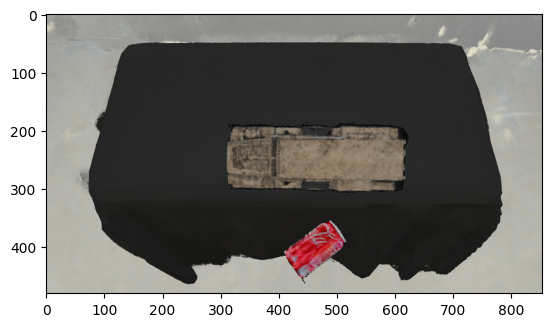

In [86]:
points_composed, points_composed_world, points_2d, image_composed, object_inds = network()
plt.figure()
plt.imshow(image_composed)
colors = np.reshape(image_composed, (-1, 3))
colors = np.hstack([colors, np.ones((colors.shape[0], 1))])
send_point_cloud(np.hstack((points_composed_world.detach().cpu().numpy(), colors)), has_alpha=False)

# tmp = np.ones(points_composed_world.shape)
# tmp[:, :2] = points_2d.detach().cpu().numpy()
# send_point_cloud(np.hstack((tmp, colors)), has_alpha=False, topic='point_cloud_2')
# print(torch.max(points_2d))

0.12544727325439453


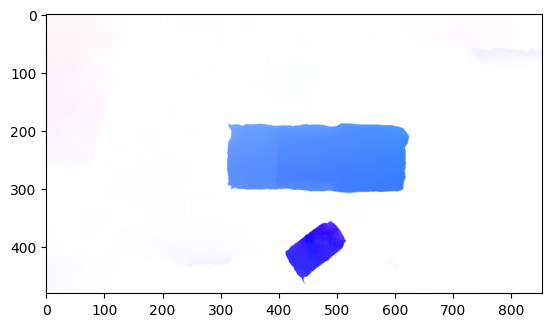

In [87]:
image1 = np.array(255*image_composed[:,:,:3]).astype(np.uint8)
image2 = ros_image[:,:,:3]
image1 = torch.from_numpy(image1).permute(2, 0, 1).float().unsqueeze(0).to(device)
image2 = torch.from_numpy(image2).permute(2, 0, 1).float().unsqueeze(0).to(device)

flow = get_flow(model, image1, image2)

plt.figure()
vis_flow = flow_to_image(flow)
plt.imshow(vis_flow)

[WARN] [1696025578.062322809] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]


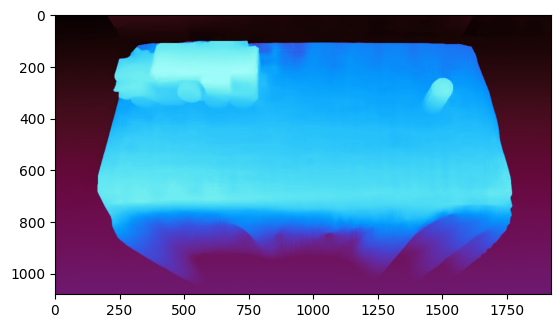

In [88]:
from utils.visualization import vis_disparity

def get_disparity(model_stereo, left, right):
    padding_factor = 32
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]


    sample = {'left': left,
              'right': right
              }
    val_transform_list = [transforms.ToTensor(), transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)]
    val_transform = transforms.Compose(val_transform_list)
    sample = val_transform(sample)
    left = sample['left'].to(device).unsqueeze(0)  # [1, 3, H, W]
    right = sample['right'].to(device).unsqueeze(0)  # [1, 3, H, W]

    nearest_size = [int(np.ceil(left.size(-2) / padding_factor)) * padding_factor,
                    int(np.ceil(left.size(-1) / padding_factor)) * padding_factor]

    fixed_inference_size = [val//2 for val in nearest_size] 
    print(fixed_inference_size)
#     fixed_inference_size = [288, 480]
#     fixed_inference_size = None

    # resize to nearest size or specified size
    inference_size = nearest_size if fixed_inference_size is None else fixed_inference_size

    ori_size = left.shape[-2:]

    if inference_size[0] != ori_size[0] or inference_size[1] != ori_size[1]:
        left = F.interpolate(left, size=inference_size,
                             mode='bilinear',
                             align_corners=True)
        right = F.interpolate(right, size=inference_size,
                              mode='bilinear',
                                  align_corners=True)

    with torch.no_grad():
        import time
        for i  in range(1):
            start = time.time()
            pred_disp = model_stereo(left, right,
                               attn_type='self_swin2d_cross_swin1d',
                               attn_splits_list=[2, 8],
                               prop_radius_list=[-1, 1],
                               corr_radius_list=[-1, 4],
                               num_reg_refine=3,
                               task='stereo',
                               )['flow_preds'][-1]  # [1, H, W]
#             print(time.time() - start)



    if inference_size[0] != ori_size[0] or inference_size[1] != ori_size[1]:
        pred_disp = F.interpolate(pred_disp.unsqueeze(1), size=ori_size, mode='nearest').squeeze(1)  # [1, H, W]


    disp = pred_disp[0].cpu().numpy()
    return disp 



left, left_pose = get_image_tf_pair(image_topics=['camera_image_l'], tf_names=['camera_frame_l'])
left_pose = left_pose[0]
left = left[0]

right, right_pose = get_image_tf_pair(image_topics=['camera_image_r'], tf_names=['camera_frame_r'])
right_pose = right_pose[0]
right = right[0]



left = left[:,:,:3].astype(np.float32)
left_ori = left.copy() 
right = right[:,:,:3].astype(np.float32)

disp = get_disparity(model_stereo, left, right)

plt.figure()
plt.imshow(vis_disparity(disp))


In [89]:
def get_points_from_disparity(disp, left_pose, right_pose):
    baseline = np.sqrt(np.sum((left_pose[:3,3]-right_pose[:3,3])**2))
    fov = 69.4*(math.pi/180.0)
    focal = 2*np.tan(fov/2.0)
    depth = baseline * focal / disp
    depth = depth/2.0 # correct for scaling

    points = 1000*get_points(depth, np.eye(4), math.pi*(42.5/180.0), depth.shape[1], depth.shape[0])
    Rt = left_pose[:3, :3].transpose(0,1)
    points = (points @ Rt) + np.reshape(left_pose[:3, 3], (1, 3)) 
    return points 

stereo_points = get_points_from_disparity(disp, left_pose, right_pose)
tmp = left_ori/255
tmp[tmp>1.0] = 1.0

stereo_colors = np.reshape(tmp, (-1, 3))
stereo_colors = np.hstack([stereo_colors, np.ones((stereo_colors.shape[0], 1))])
send_point_cloud(np.hstack((stereo_points, stereo_colors)), has_alpha=False)




In [ ]:
from torch.nn.functional import grid_sample 
import cvxpy as cp
from qpsolvers import solve_qp
import time

def send_obj_tf(obj):
    testbed = testbed_map[obj]
    T_box = np.eye(4, 4)    
    T_box[0, 3] = testbed.crop_box()[1, 3]
    T_box[1, 3] = testbed.crop_box()[0, 3]
    T_box[2, 3] = testbed.crop_box()[2, 3]
    T = network.tf_nerf_cam[obj].cpu().numpy().astype(np.float64)
    tf_cam_world = network.tf_cam_world.cpu().numpy().astype(np.float64)
    T = tf_cam_world @ T @ T_box 
    T[:3, :3] = T[:3, :3].transpose() 
    send_tf(obj, T)

def update_tf(obj, T):
    T_tensor = torch.from_numpy(T).to(device)
    T_new = torch.inverse(network.tf_cam_world) @ T_tensor @ network.tf_cam_world @ network.tf_nerf_cam[obj]
    network.tf_nerf_cam[obj] = T_new 

def calc_transform(object_points, target_object_points):
    A = object_points
    B = target_object_points

    centriodA = np.reshape(np.mean(A, axis=1), (3,1))
    centriodB = np.reshape(np.mean(B, axis=1), (3,1))

    H = (A-centriodA)@(B-centriodB).transpose()
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[2,:] *= -1
        R = Vt.T @ U.T
        assert np.linalg.det(R) > 0
    
    P = centriodB - R@centriodA
    
    return R, P

    
    
while True:
    # def find_matches():

    left, left_pose = get_image_tf_pair(image_topics=['camera_image_l'], tf_names=['camera_frame_l'])
    left_pose = left_pose[0]
    left = left[0]
    image2 = left[:,:,:3]
    image2 = torch.from_numpy(image2).permute(2, 0, 1).float().unsqueeze(0).to(device)
    left = left[:,:,:3].astype(np.float32)
    stereo_colors = np.reshape(left/255, (-1, 3))
    stereo_colors = np.hstack([stereo_colors, np.ones((stereo_colors.shape[0], 1))])

    right, right_pose = get_image_tf_pair(image_topics=['camera_image_r'], tf_names=['camera_frame_r'])
    right_pose = right_pose[0]
    right = right[0]
    right = right[:,:,:3].astype(np.float32)
    start = time.time()
    disp = get_disparity(model_stereo, left, right)
    stereo_points = get_points_from_disparity(disp, left_pose, right_pose)
    print(time.time()-start)
    
    grid_points = np.reshape(stereo_points, (disp.shape[0], disp.shape[1], 3))
    grid_points = torch.from_numpy(grid_points)

    find_objects = {'coke':2, 'truck':1}
    object_points_map = {}    
    
    for it2 in range(1):     
        points_composed, points_composed_world, points_2d, image_composed, object_inds = network()    

        image1 = np.array(255*image_composed[:,:,:3]).astype(np.uint8)
        image1 = torch.from_numpy(image1).permute(2, 0, 1).float().unsqueeze(0).to(device)
        flow = get_flow(model, image1, image2)
        grid_flow = np.reshape(flow, (image_composed.shape[0], image_composed.shape[1], 2))
        grid_flow[:,:,0] = 2*grid_flow[:,:,0]/image_composed.shape[1]
        grid_flow[:,:,1] = 2*grid_flow[:,:,1]/image_composed.shape[0]
        grid_flow_mag = np.sqrt(np.sum(grid_flow**2, axis=2))

        [Xgrid, Ygrid] = np.meshgrid(np.linspace(-1.0, 1.0, image_composed.shape[1]), np.linspace(-1.0, 1.0, image_composed.shape[0]))
        grid_base  = np.stack([Xgrid, Ygrid], axis=2);
        grid_input = grid_base + grid_flow 
        grid_input = torch.from_numpy(grid_input)


        target_points = grid_sample(grid_points.transpose(0, 2).transpose(1, 2).unsqueeze(axis=0), grid_input.unsqueeze(axis=0), mode='nearest', padding_mode='border') # align_corners=None
        target_points = torch.reshape(target_points,(3, -1))
        target_points = target_points.transpose(0,1)
        target_points = target_points.to(device)


        objs = [v for v in find_objects.keys()]
        for obj in objs:
            obj_ind = find_objects[obj]
            object_points = points_composed_world[object_inds.flatten()==obj_ind,:].detach().cpu().numpy()
            target_object_points = target_points[object_inds.flatten()==obj_ind,:].detach().cpu().numpy()
            R = np.eye(3, 3, dtype=np.float32)
            P = np.zeros((3, 1), dtype=np.float32)
            T = np.eye(4,4, dtype=np.float32)
            num_points = 10

#             num_hits = 0
#             best_quality = 999999999999999999.0
            for attempt in range(20):
                if object_points.shape[0] < num_points:
                    break
#                 if num_hits >= 5:
#                     break
        
                inds = np.random.choice(object_points.shape[0], num_points, replace=False)
                
                R, P = calc_transform(object_points[inds, :].transpose(), target_object_points[inds, :].transpose())
            
                matched_points = (object_points @ R.transpose()) + np.reshape(P, (1, 3)) 
                quality = np.sqrt( np.sum( (matched_points-target_object_points)**2,axis=1) )
                quality_inds = np.argsort(quality)
                quality_inds = quality_inds[:(len(quality_inds)*5)//10]
                quality = quality[quality_inds]
                quality = np.max(quality)

                if quality > 0.02: # 0.025 is ideal
                    continue
                else:
                    sub_inds = np.linspace(0, len(quality_inds)-1, 100, dtype=np.int32)
                    quality_inds = quality_inds[sub_inds]
                
                    R, P = calc_transform(object_points[quality_inds, :].transpose(), target_object_points[quality_inds, :].transpose())
            
#                     num_hits += 1
                    print(quality)
#                     if quality < best_quality:
#                         best_quality = quality
                    print(f'found match: {obj}!')
                    object_points_map[obj] = object_points
                    T[:3, :3] = R
                    T[:3, 3] = P.flatten()
                    update_tf(obj, T)
                    find_objects.pop(obj)
                    break
                
        for obj in ['truck', 'coke']:
            send_obj_tf(obj)
                    
        for obj in find_objects:
            network.reset_transform(obj)
        if len(find_objects)==0:
            break
        print(f'iter: {it2}')

    if len(find_objects)>=0:
        pass
#         colors = np.reshape(image_composed, (-1, 3))
#         colors = np.hstack([colors, np.ones((colors.shape[0], 1))])
#         colors = colors[np.reshape(object_inds == 1, (-1,)), :]
#         colors[:,:3] = colors[:,:3]*.2
#         colors[:, 1] = 1
#         matched_points = (object_points_map['truck'] @ R.transpose()) + np.reshape(P, (1, 3)) 
#         vals = np.hstack((matched_points, colors))
#         send_point_cloud(vals, has_alpha=False, topic='point_cloud_2')

        points_composed, points_composed_world, points_2d, image_composed_innner, object_inds = network()    
        colors = np.reshape(image_composed_innner, (-1, 3))
        colors = np.hstack([colors, np.ones((colors.shape[0], 1))])
        send_point_cloud(np.hstack((points_composed_world.detach().cpu().numpy(), colors)), has_alpha=False)


# import cProfile
# cProfile.run("find_matches()")

print(quality)
print(attempt)

plt.figure()
vis_flow = flow_to_image(flow)
plt.imshow(vis_flow)



[WARN] [1696025583.058384060] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.16644787788391113
0.11828756332397461
0.009778433738965375
found match: truck!
iter: 0


[WARN] [1696025583.765433456] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025585.799846135] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.16894912719726562
0.12391138076782227
0.009865544511798023
found match: truck!
iter: 0


[WARN] [1696025586.508396130] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025588.956684048] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.20319199562072754
0.11065244674682617
0.010549952494714692
found match: truck!
iter: 0


[WARN] [1696025591.853561926] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18165946006774902
0.11000609397888184
0.010134804588965499
found match: truck!
iter: 0


[WARN] [1696025592.754208970] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025594.731669635] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18938493728637695
0.11049890518188477
0.018601195913725742
found match: coke!
0.013637463034244573
found match: truck!


[WARN] [1696025595.642158591] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17629432678222656
0.11125993728637695
0.01069840337580361
found match: truck!
iter: 0


[WARN] [1696025598.488011219] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025600.768972563] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.22353053092956543
0.1222386360168457
0.01849232657884
found match: coke!
0.00995547362789833
found match: truck!


[WARN] [1696025601.584025293] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025603.676433643] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17338228225708008
0.11043548583984375
0.003140120662693861
found match: coke!
0.009325805323336153
found match: truck!


[WARN] [1696025607.174731582] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17873358726501465
0.11307239532470703
0.00899237675388376
found match: truck!
iter: 0


[WARN] [1696025607.922768573] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025610.067963725] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.16840362548828125
0.12212824821472168
0.011521113450079874
found match: truck!
iter: 0


[WARN] [1696025610.844880455] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17719459533691406
0.11168861389160156
0.016598416422901937
found match: coke!
0.009904999838620292
found match: truck!


[WARN] [1696025614.293265279] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025616.554284576] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.22354531288146973
0.13317394256591797
0.009731836617382033
found match: truck!
iter: 0


[WARN] [1696025617.593305144] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025619.863389805] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1872413158416748
0.11696434020996094
0.012206667407432155
found match: truck!
iter: 0


[WARN] [1696025623.567545284] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1778104305267334
0.13047146797180176
0.009900250882683398
found match: truck!
iter: 0


[WARN] [1696025624.329341519] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025626.968406325] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.23464369773864746
0.1099710464477539
0.012937518702404066
found match: coke!
0.012064647906686606
found match: truck!


[WARN] [1696025627.960212850] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17963385581970215
0.1089925765991211
0.011316597382510802
found match: coke!
0.012061279289217502
found match: truck!


[WARN] [1696025631.092191100] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025633.149938922] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18773269653320312
0.1109013557434082
0.011512815475949165
found match: coke!
0.014751101812247001
found match: truck!


[WARN] [1696025633.811781217] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025635.810227030] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18193793296813965
0.129225492477417
0.007509066527326669
found match: coke!
0.009905972977744733
found match: truck!


[WARN] [1696025638.493369137] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18302273750305176
0.11388397216796875
0.005296974007882735
found match: coke!
0.015554889019690236
found match: truck!


[WARN] [1696025639.343751422] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025641.332830070] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1783435344696045
0.11241316795349121
0.0050713118771477895
found match: coke!
0.00897700119203085
found match: truck!


[WARN] [1696025642.143349235] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.16537976264953613
0.12806105613708496
0.005917681244426789
found match: coke!
0.010337011329013985
found match: truck!


[WARN] [1696025645.041443694] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025647.131182484] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.16722655296325684
0.1258068084716797
0.008490526874523847
found match: coke!
0.01804409749544562
found match: truck!


[WARN] [1696025647.815135827] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025650.019555752] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2063736915588379
0.12009763717651367
0.005588086538801447
found match: coke!
0.009903620241304293
found match: truck!


[WARN] [1696025652.913554343] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1773843765258789
0.1083211898803711
0.006694456429548411
found match: coke!
0.008720702242150673
found match: truck!


[WARN] [1696025653.783669801] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025655.986435528] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.16742920875549316
0.11893534660339355
0.016347769707292695
found match: coke!
0.01077578616835664
found match: truck!


[WARN] [1696025656.706190841] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.16384005546569824
0.1382737159729004
0.006179385396678195
found match: coke!
0.008685835028968143
found match: truck!


[WARN] [1696025659.343515092] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025661.468945850] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18021464347839355
0.11227107048034668
0.012386354029044177
found match: coke!
0.010906026657822265
found match: truck!


[WARN] [1696025662.375472662] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025664.578986113] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1668245792388916
0.11961913108825684
0.006560468726789208
found match: coke!
0.009022494428174852
found match: truck!


[WARN] [1696025667.275215213] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.22058796882629395
0.12885046005249023
0.016691415152674347
found match: coke!
0.01079273008421832
found match: truck!


[WARN] [1696025668.798445977] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025670.806578756] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.23988652229309082
0.11446762084960938
0.00542744226106916
found match: coke!
0.008556590888915977
found match: truck!


[WARN] [1696025671.820628360] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19307231903076172
0.11098957061767578
0.017956066297426725
found match: coke!
0.012147441253881635
found match: truck!


[WARN] [1696025675.090348743] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025677.634036725] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.20555496215820312
0.13621115684509277
0.005903273839130153
found match: coke!
0.009633347272767422
found match: truck!


[WARN] [1696025678.600329266] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025680.692443107] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.20163440704345703
0.11460733413696289
0.007047408610427181
found match: coke!
0.01112882196423128
found match: truck!


[WARN] [1696025683.872981195] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.20627474784851074
0.11008667945861816
0.007745960504208057
found match: coke!
0.012197659279546328
found match: truck!


[WARN] [1696025685.295728761] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025687.715991165] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19614744186401367
0.10932517051696777
0.007057056761981677
found match: coke!
0.009928101246803883
found match: truck!


[WARN] [1696025688.694471390] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1905508041381836
0.11232376098632812
0.011643907167364185
found match: coke!
0.011071824608860725
found match: truck!


[WARN] [1696025692.060361134] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025694.063064184] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1997969150543213
0.11018228530883789
0.01776413529364109
found match: coke!
0.011865997405539508
found match: truck!


[WARN] [1696025695.492598479] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025697.643540797] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19507312774658203
0.1120612621307373
0.018622596333842216
found match: coke!
0.010171903478290898
found match: truck!


[WARN] [1696025701.385190201] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.22826290130615234
0.11193728446960449
0.01720637301418862
found match: coke!
0.010105553617831909
found match: truck!


[WARN] [1696025702.464156479] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025704.774686276] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18233299255371094
0.12922930717468262
0.019880667184782173
found match: coke!
0.010881018568103763
found match: truck!


[WARN] [1696025705.831944820] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.20302414894104004
0.12100839614868164
0.015424186826088251
found match: coke!
0.009713545942060827
found match: truck!


[WARN] [1696025709.028590920] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025711.411167947] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.20350265502929688
0.11814475059509277
0.013191465880208073
found match: coke!
0.008892766132421709
found match: truck!


[WARN] [1696025712.287312999] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025715.201497421] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19023561477661133
0.11388826370239258
0.012021769043179677
found match: coke!
0.009087972511422307
found match: truck!


[WARN] [1696025719.087298084] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1804821491241455
0.12033653259277344
0.01006284602797971
found match: coke!
0.009642979161987536
found match: truck!


[WARN] [1696025720.069800240] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025722.432364628] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19124484062194824
0.1093902587890625
0.009851133235473814
found match: coke!
0.009829698437308925
found match: truck!


[WARN] [1696025723.393803112] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17767810821533203
0.11204218864440918
0.01354865761425537
found match: coke!
0.00886777663308951
found match: truck!


[WARN] [1696025726.433630285] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025728.611480196] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.16888785362243652
0.12223386764526367
0.006131151127235058
found match: coke!
0.008706255926478265
found match: truck!


[WARN] [1696025729.285345527] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025731.407320006] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17867493629455566
0.11098527908325195
0.005054482487128351
found match: coke!
0.010379121996477517
found match: truck!


[WARN] [1696025735.075568671] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2024850845336914
0.10896635055541992
0.005734772799838772
found match: coke!
0.009064546925490413
found match: truck!


[WARN] [1696025735.853341326] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025737.986066117] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1803760528564453
0.11074304580688477
0.005803115173114364
found match: coke!
0.014465702258328206
found match: truck!


[WARN] [1696025738.805317139] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1805250644683838
0.13646697998046875
0.006456397399271625
found match: coke!
0.009923500436028621
found match: truck!


[WARN] [1696025741.548105662] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025743.643312356] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18431544303894043
0.11469221115112305
0.008281401758840345
found match: coke!
0.008873018197604545
found match: truck!


[WARN] [1696025744.333322825] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025746.435737741] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.16746306419372559
0.12336111068725586
0.006967354302332941
found match: coke!
0.012707554978224818
found match: truck!


[WARN] [1696025749.121258192] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19327735900878906
0.11557984352111816
0.007003258557802604
found match: coke!
0.010607171574824319
found match: truck!


[WARN] [1696025749.986339184] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025751.981683919] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17546343803405762
0.11619257926940918
0.005951088635712504
found match: coke!
0.010128705113428995
found match: truck!


[WARN] [1696025752.792964865] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.26114606857299805
0.1159505844116211
0.007742953973288829
found match: coke!
0.008911607972020005
found match: truck!


[WARN] [1696025755.827435903] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025758.009884484] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18720650672912598
0.10938501358032227
0.0066795281029069205
found match: coke!
0.009289184204939394
found match: truck!


[WARN] [1696025759.003147400] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025761.101223001] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1778700351715088
0.11289787292480469
0.013613375846478174
found match: coke!
0.010297675256590923
found match: truck!


[WARN] [1696025764.168796473] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.24286341667175293
0.11162662506103516
0.00653879858660765
found match: coke!
0.008738423948269333
found match: truck!


[WARN] [1696025765.284814368] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025767.478108303] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1822664737701416
0.11194658279418945
0.006642638707227996
found match: coke!
0.015648044974118095
found match: truck!


[WARN] [1696025768.432033458] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.20324397087097168
0.11758828163146973
0.009541097417094791
found match: coke!
0.015223107096954971
found match: truck!


[WARN] [1696025771.391318568] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025773.840058293] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17035698890686035
0.11047649383544922
0.009086476887087892
found match: coke!
0.01051648096186003
found match: truck!


[WARN] [1696025775.443855865] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025777.552182094] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17880821228027344
0.10988354682922363
0.007540708179251808
found match: coke!
0.011512524606556883
found match: truck!


[WARN] [1696025780.483617989] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17786502838134766
0.12264490127563477
0.007372757927077551
found match: coke!
0.009786235206524545
found match: truck!


[WARN] [1696025781.295682739] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025783.518171713] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18082475662231445
0.11687922477722168
0.00925807929539831
found match: coke!
0.011083514284410833
found match: truck!


[WARN] [1696025784.370674254] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.22318673133850098
0.11088395118713379
0.008743266705936148
found match: coke!
0.008968790353728143
found match: truck!


[WARN] [1696025787.722542067] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025790.172320513] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18241429328918457
0.11417984962463379
0.010565287700689712
found match: coke!
0.015181760662873583
found match: truck!


[WARN] [1696025791.058891001] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025794.043025705] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.16477656364440918
0.150923490524292
0.009224137655359763
found match: coke!
0.009669234840623365
found match: truck!


[WARN] [1696025797.331218080] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17360186576843262
0.11356782913208008
0.01936828218389921
found match: coke!
0.009062193421526615
found match: truck!


[WARN] [1696025798.222135417] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025800.493128109] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.23576045036315918
0.12743544578552246
0.01666877857338074
found match: coke!
0.009328161291696327
found match: truck!


[WARN] [1696025801.316050013] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.21921777725219727
0.12030982971191406
0.019047660102343263
found match: coke!
0.009114416430358485
found match: truck!


[WARN] [1696025804.707212169] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025806.965483751] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1966233253479004
0.12408781051635742
0.01795034860659955
found match: coke!
0.009128446560833746
found match: truck!


[WARN] [1696025808.183494263] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025810.451300449] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19780182838439941
0.11423039436340332
0.01197029194102113
found match: coke!
0.00924736107085205
found match: truck!


[WARN] [1696025813.580209799] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.20287251472473145
0.12008976936340332
0.00898401390821415
found match: coke!
0.012079185322738911
found match: truck!


[WARN] [1696025814.710016540] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025817.329219442] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.21358275413513184
0.10826921463012695
0.007144795468862264
found match: coke!
0.009685061818124893
found match: truck!


[WARN] [1696025818.286940322] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18743586540222168
0.1130216121673584
0.005192001264901519
found match: coke!
0.012091723738087558
found match: truck!


[WARN] [1696025821.080473756] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025823.479042499] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19258928298950195
0.12445664405822754
0.004548795701964285
found match: coke!
0.00914325460168612
found match: truck!


[WARN] [1696025824.307836806] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025826.386984298] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18324756622314453
0.13421201705932617
0.0044098076235595425
found match: coke!
0.009462333025407051
found match: truck!


[WARN] [1696025829.546262729] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17627906799316406
0.11959576606750488
0.00478741090194983
found match: coke!
0.008966746283364605
found match: truck!


[WARN] [1696025830.204412607] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025832.257060488] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.16765499114990234
0.1356813907623291
0.0049297317378738745
found match: coke!
0.013226226287531173
found match: truck!


[WARN] [1696025832.921815741] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18304157257080078
0.11888957023620605
0.005079986930187877
found match: coke!
0.00979814514046195
found match: truck!


[WARN] [1696025835.929937230] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025838.383184462] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17769432067871094
0.11126470565795898
0.01815618145386583
found match: coke!
0.00939133335203506
found match: truck!


[WARN] [1696025839.182027933] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025841.535535116] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1758120059967041
0.11198830604553223
0.005465974375576869
found match: coke!
0.009775344952116448
found match: truck!


[WARN] [1696025844.722026895] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.20383453369140625
0.1337902545928955
0.012604365778242603
found match: coke!
0.011739721878210709
found match: truck!


[WARN] [1696025845.553825340] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025847.669971865] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19973993301391602
0.11405491828918457
0.005243436893263692
found match: coke!
0.009253911403732188
found match: truck!


[WARN] [1696025848.656320474] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19150543212890625
0.11411738395690918
0.004778967723638413
found match: coke!
0.00969367478033888
found match: truck!


[WARN] [1696025851.891283791] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025854.234584120] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1863861083984375
0.11024117469787598
0.004615788286923415
found match: coke!
0.009355989426776087
found match: truck!


[WARN] [1696025855.120587306] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025857.211043541] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17818951606750488
0.10928630828857422
0.005144530562510676
found match: coke!
0.011632149035785052
found match: truck!


[WARN] [1696025860.051003253] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18027043342590332
0.11036300659179688
0.005205971562924222
found match: coke!
0.00882133031591447
found match: truck!


[WARN] [1696025860.796158230] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025863.138002467] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19109678268432617
0.1371171474456787
0.006934243542228252
found match: coke!
0.00964114407782684
found match: truck!


[WARN] [1696025863.844572655] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18509602546691895
0.11067438125610352
0.007675348202971185
found match: coke!
0.008854262568159223
found match: truck!


[WARN] [1696025867.655406572] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025870.039277736] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19644665718078613
0.11270427703857422
0.005417665338358895
found match: coke!
0.009879932213984215
found match: truck!


[WARN] [1696025870.870451912] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025873.288448297] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18975043296813965
0.11158490180969238
0.013573980547621002
found match: coke!
0.016417973387168286
found match: truck!


[WARN] [1696025876.253253984] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19071030616760254
0.11077737808227539
0.005672507304631075
found match: coke!
0.009863698111067796
found match: truck!


[WARN] [1696025877.025619457] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025879.157200023] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19152307510375977
0.11220908164978027
0.0051589643665201365
found match: coke!
0.012311771022582851
found match: truck!


[WARN] [1696025879.923987902] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1738872528076172
0.11893081665039062
0.004227487350073343
found match: coke!
0.00922031044265139
found match: truck!


[WARN] [1696025883.412945220] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025885.571668118] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18265128135681152
0.11125373840332031
0.004677574004550517
found match: coke!
0.008824381028312317
found match: truck!


[WARN] [1696025886.541378308] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025888.602303398] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1815967559814453
0.11363482475280762
0.004395173852094196
found match: coke!
0.0092988105477411
found match: truck!


[WARN] [1696025891.787648417] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17597508430480957
0.11283183097839355
0.004970446182653911
found match: coke!
0.013434483154441887
found match: truck!


[WARN] [1696025892.786483099] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025894.804767203] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18790221214294434
0.11053347587585449
0.004455080687944454
found match: coke!
0.012562106178508729
found match: truck!


[WARN] [1696025896.137016525] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18199491500854492
0.11732149124145508
0.012911542284975671
found match: coke!
0.011609417553003046
found match: truck!


[WARN] [1696025900.043403896] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025902.399737266] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.20406150817871094
0.10963797569274902
0.007400799770480479
found match: coke!
0.009308363213014348
found match: truck!


[WARN] [1696025904.214014801] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025906.347683303] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17279720306396484
0.11402010917663574
0.004619247915005236
found match: coke!
0.018172420366059216
found match: truck!


[WARN] [1696025909.598449159] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19145798683166504
0.13450145721435547
0.004612242235520817
found match: coke!
0.009335648765650444
found match: truck!


[WARN] [1696025910.607656443] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025913.032104157] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.20423340797424316
0.13420391082763672
0.011011751233253101
found match: coke!
0.009239082221783173
found match: truck!


[WARN] [1696025914.014218000] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2021777629852295
0.12035894393920898
0.004522215885925258
found match: coke!
0.010352484701661809
found match: truck!


[WARN] [1696025917.345612478] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025919.973377588] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18697023391723633
0.1157839298248291
0.005308304417158414
found match: coke!
0.009580895519885368
found match: truck!


[WARN] [1696025921.144601625] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025923.393849521] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18094682693481445
0.11159563064575195
0.004367811516379309
found match: coke!
0.009784237917095658
found match: truck!


[WARN] [1696025926.665506576] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1988053321838379
0.10856127738952637
0.007265201535633039
found match: coke!
0.01348281097523517
found match: truck!


[WARN] [1696025927.659636963] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025929.746609409] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19456243515014648
0.12030744552612305
0.004130758983533086
found match: coke!
0.012554546128625207
found match: truck!


[WARN] [1696025930.408593721] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17410731315612793
0.12468361854553223
0.015386574783230024
found match: coke!
0.011578216245445149
found match: truck!


[WARN] [1696025934.103855236] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025936.186939349] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19543886184692383
0.11137962341308594
0.004825274535625599
found match: coke!
0.010250813856817783
found match: truck!


[WARN] [1696025937.171337138] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025939.312015576] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1867060661315918
0.11067080497741699
0.0063592035157030965
found match: coke!
0.008992874112623254
found match: truck!


[WARN] [1696025942.194525662] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18245887756347656
0.11115789413452148
0.013246950467194913
found match: coke!
0.009668601307334336
found match: truck!


[WARN] [1696025942.883101126] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025945.339046275] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18537211418151855
0.11565637588500977
0.004752636905848965
found match: coke!
0.010082387656291995
found match: truck!


[WARN] [1696025946.247978061] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.21458792686462402
0.1109778881072998
0.005482419329552312
found match: coke!
0.009545304923268131
found match: truck!


[WARN] [1696025949.636944709] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025951.915914973] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18822741508483887
0.11374735832214355
0.005085386414305427
found match: coke!
0.00960608494075838
found match: truck!


[WARN] [1696025952.828183722] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025955.346488966] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18407583236694336
0.11071443557739258
0.005038124326257833
found match: coke!
0.009983657434035176
found match: truck!


[WARN] [1696025958.201438020] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1873784065246582
0.11132121086120605
0.005108068415434982
found match: coke!
0.009345756921392024
found match: truck!


[WARN] [1696025959.625613292] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025962.018067386] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18502378463745117
0.10892295837402344
0.0070010050855590115
found match: coke!
0.00952549519553734
found match: truck!


[WARN] [1696025963.029439752] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1715996265411377
0.12123847007751465
0.006045065253331098
found match: coke!
0.010692703841328007
found match: truck!


[WARN] [1696025966.038928665] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025968.235538852] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18338537216186523
0.11112642288208008
0.006402448722571606
found match: coke!
0.00904918076229731
found match: truck!


[WARN] [1696025969.045506552] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025971.772243001] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.16640830039978027
0.11947417259216309
0.0045926148491947805
found match: coke!
0.018119606155438086
found match: truck!


[WARN] [1696025974.894613948] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17229342460632324
0.10938525199890137
0.01412061365160687
found match: coke!
0.009517446232631297
found match: truck!


[WARN] [1696025976.070596276] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025978.233893495] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18684029579162598
0.11829733848571777
0.013109099643120127
found match: coke!
0.009390612427914554
found match: truck!


[WARN] [1696025979.085141124] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2342057228088379
0.11179971694946289
0.01464414840296445
found match: coke!
0.010203219532138288
found match: truck!


[WARN] [1696025982.200778032] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025984.564469132] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2035222053527832
0.11045575141906738
0.005671548942065443
found match: coke!
0.009146101653559927
found match: truck!


[WARN] [1696025985.571271269] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025988.130351413] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18309950828552246
0.12311506271362305
0.005412459603528675
found match: coke!
0.008581535715096495
found match: truck!


[WARN] [1696025991.269516462] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19359636306762695
0.12085485458374023
0.006003894935795019
found match: coke!
iter: 0


[WARN] [1696025992.255651137] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696025994.948059950] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.20135736465454102
0.1088263988494873
0.006413134095658414
found match: coke!
iter: 0


[WARN] [1696025996.004711114] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.20068693161010742
0.1085062026977539
0.008199013643714325
found match: coke!
0.00921272585850816
found match: truck!


[WARN] [1696025999.658556163] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696026002.071386466] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2057185173034668
0.11122894287109375
0.004354046617435748
found match: coke!
0.009019251614852846
found match: truck!


[WARN] [1696026003.161677565] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696026005.593651175] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.20157694816589355
0.10931801795959473
0.005165797624107838
found match: coke!
0.009276685887453126
found match: truck!


[WARN] [1696026009.207789766] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2202000617980957
0.11037182807922363
0.0060660688819767
found match: coke!
0.017963903315546034
found match: truck!


[WARN] [1696026010.073940695] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696026012.597478227] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.3152427673339844
0.14661312103271484
0.014983496049769137
found match: coke!
0.009736746004158385
found match: truck!


[WARN] [1696026013.786630956] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17866086959838867
0.10895133018493652
0.004887351294639441
found match: coke!
iter: 0


[WARN] [1696026016.836082001] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696026019.309582059] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1802051067352295
0.11780238151550293
0.019389528518360663
found match: coke!
iter: 0


[WARN] [1696026020.153360810] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696026022.345171343] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17864751815795898
0.10971736907958984
iter: 0


[WARN] [1696026025.829497905] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18200111389160156
0.11150932312011719
0.017875779373877004
found match: coke!
iter: 0


[WARN] [1696026026.718192762] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696026029.118774229] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.21500134468078613
0.12971901893615723
0.01301055337659578
found match: coke!
0.008256644678559985
found match: truck!


[WARN] [1696026030.167176246] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.16756415367126465
0.11879682540893555
0.009169479576952813
found match: coke!
0.013345091988720637
found match: truck!


[WARN] [1696026033.170765685] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696026035.413550630] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1857008934020996
0.12009334564208984
0.0063140466312008635
found match: coke!
0.016234885068096814
found match: truck!


[WARN] [1696026036.263456939] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696026038.341961724] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18339085578918457
0.10894942283630371
0.015340607756440734
found match: coke!
0.009247319985623679
found match: truck!


[WARN] [1696026041.106682058] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18050909042358398
0.11302518844604492
0.013774991441903207
found match: coke!
0.012063243824738008
found match: truck!


[WARN] [1696026041.891422005] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696026044.384412445] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.16998505592346191
0.12256813049316406
0.018482617576624966
found match: coke!
iter: 0
18:20:45 DEBUG    GPUMemoryArena: enlarging from 468 MB to 472 MB
18:20:45 DEBUG    GPUMemoryArena: enlarging from 472 MB to 492 MB


[WARN] [1696026045.371735480] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17584466934204102
0.11204981803894043
iter: 0


[WARN] [1696026048.351621824] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696026050.579942816] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1692514419555664
0.122711181640625
0.019927786812200473
found match: truck!
iter: 0


[WARN] [1696026051.851213331] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696026054.103080035] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2124340534210205
0.11270308494567871
0.018443060375014638
found match: truck!
iter: 0


[WARN] [1696026057.496674324] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19707441329956055
0.1172480583190918
0.01682387959715506
found match: truck!
iter: 0


[WARN] [1696026058.392283593] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696026061.086036148] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.21820855140686035
0.11554884910583496
0.014843017990901177
found match: truck!
iter: 0


[WARN] [1696026062.141606423] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18473505973815918
0.11796188354492188
0.018976389753839674
found match: coke!
0.015615867608139383
found match: truck!


[WARN] [1696026066.020181020] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696026068.873472302] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19595980644226074
0.12137484550476074
0.013526945254119727
found match: coke!
0.016713348700098163
found match: truck!


[WARN] [1696026069.923812264] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696026072.146610405] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1833207607269287
0.11055994033813477
0.005822744558761737
found match: coke!
0.01642672901831286
found match: truck!


[WARN] [1696026075.791480355] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18448472023010254
0.14058852195739746
0.019427966617270094
found match: coke!
0.01894268397676665
found match: truck!


[WARN] [1696026076.772377482] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696026079.191523254] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18650603294372559
0.11108279228210449
0.006722817975433128
found match: coke!
0.013894003316669717
found match: truck!


[WARN] [1696026080.094630933] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1721799373626709
0.10967254638671875
0.013035154996799492
found match: coke!
0.01655322733324411
found match: truck!


[WARN] [1696026083.183783467] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696026085.533123264] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.17651963233947754
0.12289977073669434
0.004389703616051193
found match: coke!
0.01230206142852873
found match: truck!


[WARN] [1696026086.324924623] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696026088.672412104] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1666579246520996
0.12589621543884277
0.004641576224334222
found match: coke!
0.014885409786067933
found match: truck!


[WARN] [1696026091.718434413] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.1937267780303955
0.1194925308227539
0.006818973696738139
found match: coke!
0.017689675986643977
found match: truck!


[WARN] [1696026092.776000389] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696026095.189464827] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19376063346862793
0.11163067817687988
0.01561098225141771
found match: coke!
0.014681284397481521
found match: truck!


[WARN] [1696026096.094236447] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.20502781867980957
0.1157989501953125
0.004598558411642471
found match: coke!
iter: 0


[WARN] [1696026099.527553962] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696026101.668001597] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19463133811950684
0.11702561378479004
0.005134606514596352
found match: coke!
iter: 0


[WARN] [1696026102.903974756] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696026105.088593606] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19526004791259766
0.11154961585998535
0.005806541064203769
found match: coke!
iter: 0


[WARN] [1696026109.010201895] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19129014015197754
0.12259793281555176
0.014479089011494318
found match: coke!
0.012107750609820944
found match: truck!


[WARN] [1696026110.353712851] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696026113.337506291] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.22327709197998047
0.11191654205322266
0.00637859358196852
found match: coke!
0.018632786559281585
found match: truck!


[WARN] [1696026114.483145043] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18209123611450195
0.13072705268859863
0.014266226710526294
found match: coke!
0.009335495560967065
found match: truck!


[WARN] [1696026117.412187589] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696026119.607557439] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18058466911315918
0.11209893226623535
0.005629988845755245
found match: coke!
0.01177638448262094
found match: truck!


[WARN] [1696026120.611279404] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696026123.075717241] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18192172050476074
0.11592292785644531
0.004776284972919675
found match: coke!
0.008398989270151138
found match: truck!


[WARN] [1696026125.894712028] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18167519569396973
0.11057615280151367
0.007181527398943537
found match: coke!
0.009107553884111906
found match: truck!


[WARN] [1696026126.672632586] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696026129.052504272] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.2083733081817627
0.11186552047729492
0.019434032077064206
found match: coke!
0.011669723754702023
found match: truck!


[WARN] [1696026129.936144419] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18120384216308594
0.11210083961486816
0.004967459402804178
found match: coke!
0.009339253566107698
found match: truck!


[WARN] [1696026133.137319151] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696026135.562527958] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18176937103271484
0.10662317276000977
0.0043193639290763156
found match: coke!
0.012189085118031566
found match: truck!


[WARN] [1696026136.457166770] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1696026138.541899564] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.18062186241149902
0.1139068603515625
0.004920270732231897
found match: coke!
0.009690088486287295
found match: truck!


[WARN] [1696026141.425733309] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


[544, 960]
0.19414877891540527
0.12084484100341797
0.018642600707347523
found match: coke!
0.009711283437620141
found match: truck!


[WARN] [1696026142.215029126] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


In [ ]:
plt.figure()
vis_flow = flow_to_image(flow)
plt.imshow(vis_flow)

# _, _, _, image_composed, _ = network()
plt.figure(figsize=(10,6))
plt.imshow(image_composed)
plt.figure(figsize=(10,6))
plt.imshow(left/255)

In [ ]:
for obj in ['truck', 'block']: 
    testbed = testbed_map[obj]
    T_box = np.eye(4, 4)    
    T_box[0, 3] = testbed.crop_box()[1, 3]
    T_box[1, 3] = testbed.crop_box()[0, 3]
    T_box[2, 3] = testbed.crop_box()[2, 3]
    T = network.tf_nerf_cam[obj].cpu().numpy().astype(np.float64)
    tf_cam_world = network.tf_cam_world.cpu().numpy().astype(np.float64)
    T = tf_cam_world @ T @ T_box 
    T[:3, :3] = T[:3, :3].transpose() 
    send_tf(obj, T)


array([0., 0., 0.], dtype=float32)

In [44]:
328/3

109.33333333333333